In [1]:
import numpy as np
from scipy import special as spc
from numpy import random as r
from matplotlib import pyplot as plt

In [2]:
sigma = 10 #Sigma value from Werner 2016
theta = sigma/200 #As above.
me = 9.10938e-31 #Electron Mass
c = 3e8 #Speed of light
kb = 1.38064852e-23 #Boltzman Constant
# theta = kb T / ( m * c**2 )
# T = theta * m * c**2 / kb
T = theta*me*c**2/kb #This and the two comments preceeding are converted from Werner 2016
def sobol(n): #This process comes from Zenitani 2015 page 2 under B. Sobol method
    u = np.zeros(n)
    for i in range(u.size):
        eta = 0
        while eta**2 - u[i]**2 <= 1:
            x4 = r.rand()                
            x5 = r.rand()                 
            x6 = r.rand()
            u[i] = -T * np.log(x4*x5*x6)     
            x7 = r.rand()                 
            eta = -T * np.log(x4*x5*x6*x7)
    return(u)
def f(u): #This function comes from Zenatani 2015 page 1 equation (2).
    return(np.e**(-(np.sqrt(1+u**2)/T))*u**2)

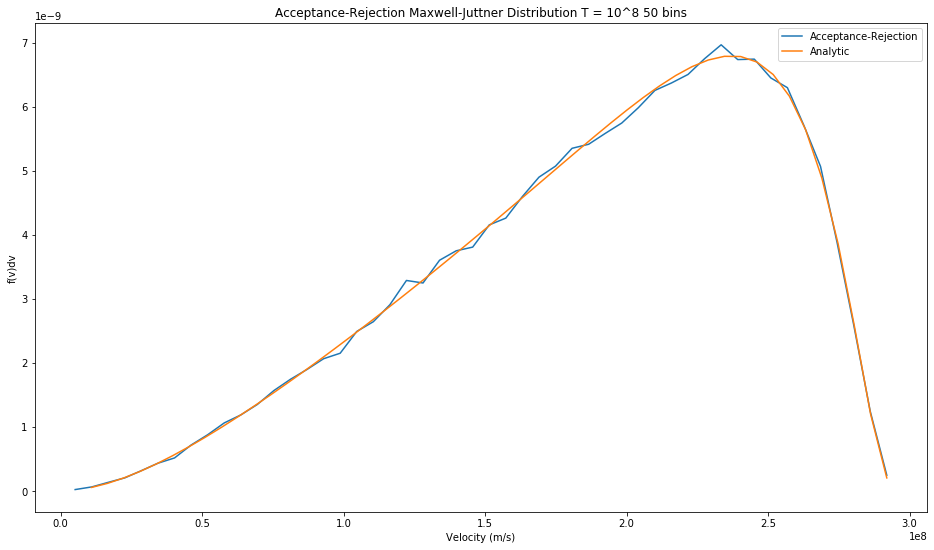

In [3]:
T = 10**8 #Temperature
n = 10**5 #Number of initialized velocities
b = 50 #Histogram Bins
us = sobol(n) #Initialized Velocities
vs = us/np.sqrt(1+us**2/c**2) #Convert u values to v values
cmjd,v1 = np.histogram(vs,bins=b,density=True) #Create a histogram sampling f(v)dv
for i in range(v1.size-1): #This loop finds the midpoint of each bin
    v1[i] =+(v1[i+1]+v1[i])/2
    i += 1
v1 = v1[0:v1.size-1] #The last value of v1 is not a midpoint
v2 = np.arange(min(v1)+(max(v1)-min(v1))/b,max(v1)+(max(v1)-min(v1))/b,(max(v1)-min(v1))/b) #The domain of the analytic f(v)dv is equal to that of the computational f(v)dv 
amjd = f(v2/np.sqrt(1-v2**2/c**2))/np.sqrt(1-v2**2/c**2)**3
#The python function f(u) is a function of u = 1/sqrt(1-v**2/c**2) v**2 and is mathematically equivalent to f(u)du
#We can show that du = gamma**3 dv We multiply by this factor and convert u to v, such that our input looks like f( v/sqrt(1-v**2/c**2) ) * 1/sqrt(1-v**2/c**2)**3
amjd *= 1/(sum(amjd)*(v2[1]-v2[0])) #Normalize the integral of the analytic distribution to be equal to that of the computational distribution.
plt.plot(v1,cmjd); plt.plot(v2,amjd)

plt.title('Acceptance-Rejection Maxwell-Juttner Distribution T = 10^8 50 bins')
plt.gca().set_xlabel('Velocity (m/s)')
plt.gca().set_ylabel('f(v)dv')
plt.gcf().set_facecolor('white')
plt.legend(('Acceptance-Rejection','Analytic'))
plt.gcf().set_size_inches(16,9)

In [4]:
def fxPrimeBoost(ux,beta): #This equation comes from Zenitani 2015 equation (33).
    Gamma = 1/np.sqrt(1-beta**2)
    gamma = np.sqrt(1+ux**2)
    return( (Gamma*gamma+T) * np.e**(-Gamma*(gamma-beta*ux)/T))
def sobolxBoost(n,beta): #The flipping method here is detailed in Zenitani 2015 Table II.
    u = np.zeros(n)
    Gamma = 1/np.sqrt(1-beta**2)
    for i in range(u.size):
        eta = 0
        while eta**2 - u[i]**2 <= 1:
            x4 = r.rand()                
            x5 = r.rand()                 
            x6 = r.rand()
            u[i] = -T * np.log(x4*x5*x6)     
            x7 = r.rand()                 
            eta = -T * np.log(x4*x5*x6*x7)
        x1 = r.rand()
        ux = u[i]*(2*x1-1)
        x9 = r.rand()
        if -beta*ux/np.sqrt(1+u[i]**2) > x9:
            ux = -ux
        u[i] = Gamma * ( ux + beta*np.sqrt(1+u[i]**2) )
    return(u)

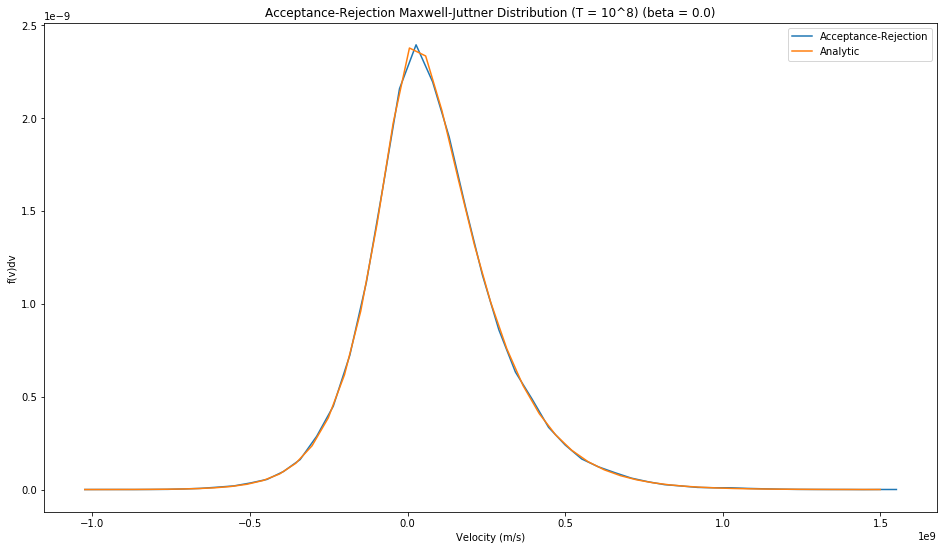

In [5]:
T = 10**8 #System Temperature
beta = 0.2 #Boost velocity
n = 10**5 #Number of initialized particles
b = 50 #Number of bins
us = sobolxBoost(n,beta) #Sample of the boosted MJ Distribution.
cmjd, u1 = np.histogram(us,bins=b,density=True) #Create a histogram sampling f(ux')dux'
for i in range(u1.size-1): #This loop finds the midpoint of each bin
    u1[i] = (u1[i+1] + u1[i])/2
u1 = u1[0:u1.size-1]  #The last value of v1 is not a midpoint
u2 = np.arange(u1[0],u1[-1],(u1[-1]-u1[0])/b)
amjd = fxPrimeBoost(u2,beta)
amjd = amjd/(sum(amjd)*(u2[1]-u2[0])) #Normalize distribution such that its integral in this range is equal to one.


plt.plot(u1,cmjd)
plt.plot(u2,amjd)

plt.title('Acceptance-Rejection Maxwell-Juttner Distribution (T = 10^8) (beta = 0.0)')
plt.gca().set_xlabel('Velocity (m/s)')
plt.gca().set_ylabel('f(v)dv')
plt.gcf().set_facecolor('white')
plt.legend(('Acceptance-Rejection','Analytic'))
plt.gcf().set_size_inches(16,9)